This notebook demostrates how to load landsat data and bom rainfall grids, calculate NDVI, calculate the mass residual curve from the rainfall data, index the ndvi data by the averaged residual mass curve and run a linear regression on this indexed data. The application is to determine what change in vegetation condition occurs across years as a result of annual rainfall variability.

Completed as part of the November 2017 DEA goehack

Neil SYmington - neil.symington@ga.gov.au

In [1]:
#for writing to error files:
from __future__ import print_function
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser
from datetime import datetime
from scipy import stats
#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys
import os.path

from IPython.display import display
import ipywidgets as widgets

#####These not needed for raijin::::
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.dates
import matplotlib as mpl

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

In [2]:
def load_nbart(sensor,query,bands_of_interest): 
    '''loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written 23-08-2017 based on dc v1.5.1'''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            # nbarT is correctly used to correct terrain by replacing -999.0 with nan
            ds=ds.where(ds!=-999.0)
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

In [3]:
#tell the datacube which app to use
dc = datacube.Datacube(app='dc-nbar')

In [4]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Define temporal range
start_of_epoch = '1987-01-01'
#start_of_epoch = '2016-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2017-12-31'

In [5]:
#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     #'green',
                     'red',
                     'nir',
                     #'swir1',
                     #'swir2'
                     ]

In [6]:
shape_file = ('/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/reeves_lake_sml_poly.shp')
# open all the shapes within the shape file
shapes = fiona.open(shape_file)
#choose the index of the polygon you want within the shape file
i =0
#copy attributes from shapefile and define shape_name
geom_crs = geometry.CRS(shapes.crs_wkt)
geo = shapes[i]['geometry']
geom = geometry.Geometry(geo, crs=geom_crs)
geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)
print(shape_name)

reeves_lake_sml_poly_0


In [7]:
query = {
    'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom,
}

In [8]:
#If not using a polygon/polyline, enter lat/lon here manually
#lat_max = -14.886385
#lat_min = -14.921916
#lon_max = 128.670053
#lon_min = 128.62809
#query['x'] = (lon_min, lon_max)
#query['y'] = (lat_max, lat_min)

In [9]:
#this is done separately instead of in a loop because the datasets can be quite large.
#currently this is a way of memory handling -there is probably a better way of doing it.
sensor1_nbart=load_nbart('ls5',query,bands_of_interest)
sensor2_nbart=load_nbart('ls7',query,bands_of_interest)
sensor3_nbart=load_nbart('ls8',query,bands_of_interest)

loading ls5_nbart_albers
loaded ls5_nbart_albers
making mask ls5_pq_albers
masked ls5_nbart_albers with ls5_pq_albers and filtered terrain
loading ls7_nbart_albers
loaded ls7_nbart_albers
making mask ls7_pq_albers
masked ls7_nbart_albers with ls7_pq_albers and filtered terrain
loading ls8_nbart_albers
loaded ls8_nbart_albers
making mask ls8_pq_albers
masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


In [10]:
##______these cells edited by Bex, to check effect of concatenating and sorting on the results----

In [11]:
#make an array of all the clean sensor data
sensor_list = []
for sensor in [sensor1_nbart, sensor2_nbart, sensor3_nbart]:
    if sensor is not None:
        sensor_list.append(sensor)
all_sens = xr.concat(sensor_list,dim='time')
#steal affine for use in transforming image coords later on
affine = all_sens.affine

In [12]:
del sensor1_nbart
del sensor2_nbart
del sensor3_nbart
del sensor_list

In [13]:
### sort by time so that sensors are interleaved properly

In [14]:
all_sens =all_sens.sortby('time')

In [15]:
# all_sens = xr.concat([sensor1_nbart, sensor2_nbart, sensor3_nbart], 'time')
# #all_sens.sortby('time')

In [16]:
all_sens['ndvi'] = (all_sens['nir'] - all_sens['red']) / (all_sens['nir'] + all_sens['red'])

# Load bom_rainfall grids from the datacube (or from file)

In [18]:
#setup rain directory where we have put our pickle data
rainpath ='/g/data/r78/rjd547/data_for_notebooks/timesliced_linear_reg_data/'

In [19]:
# #setup rain directory where we have put our pickle data
# rainpath ='/g/data1/zk34/njs547/Rainfall_EK'

In [20]:
try:
        os.mkdir(rainpath)
except OSError as err:
        print("OS error: {0}".format(err))

OS error: [Errno 17] File exists: '/g/data/r78/rjd547/data_for_notebooks/timesliced_linear_reg_data/'


In [21]:
# Edit query if need be

query['time'] = ('1978-01-01', '2017-11-01')

In [22]:
import pickle

try:
    #try to get the rain data from a pickle file saved earlier
    f = open(rainpath+'/DEA_Hack_rainfall_data_L.pkl', 'rb')
    rain = pickle.load(f)
    Studysite_rain = rain['Studysite_rain']
    print('loaded rainfall grids from file:'+rainpath+'DEA_Hack_rainfall_data.pkl')
    f.close()
except:
    #Grab bom_rainfall_grids from the datacube
    print('loading bom rainfall grids from datacube')
    Studysite_rain = dc.load(product = 'bom_rainfall_grids', **query)
    #make a dictionary of the data we want to save
    vars2pickle = {'Studysite_rain':Studysite_rain}
    f = open(rainpath+'/DEA_Hack_rainfall_data_L.pkl', 'wb')
    pickle.dump(vars2pickle,f) 
    print('saving rainfall data to file')
    #pickle.dump(vars2pickle,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
    f.close()

loading bom rainfall grids from datacube
saving rainfall data to file


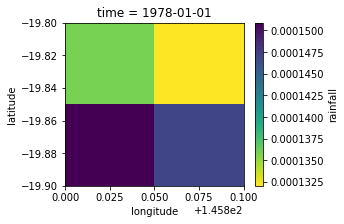

In [23]:
plt.figure(figsize=(4,3))
fig = Studysite_rain.rainfall.isel(time = [0]).plot()
#reverse the colourmap so high rainfall is blue
fig.set_cmap('viridis_r')
#print (Studysite_rain_masked)
plt.show()

In [24]:
#resample xarray Dataset Studysite_rain by year 'AS' 
month_sum = Studysite_rain.resample('MS', dim='time', how='sum', keep_attrs=True)

In [25]:
print(month_sum)

<xarray.Dataset>
Dimensions:    (latitude: 2, longitude: 2, time: 432)
Coordinates:
  * latitude   (latitude) float64 -19.82 -19.88
  * longitude  (longitude) float64 145.8 145.9
  * time       (time) datetime64[ns] 1978-01-01 1978-02-01 1978-03-01 ...
Data variables:
    rainfall   (time, latitude, longitude) float32 139.661 138.572 136.298 ...
Attributes:
    crs:      EPSG:4326


<xarray.DataArray 'time' (time: 432)>
array(['1978-01-01T00:00:00.000000000', '1978-02-01T00:00:00.000000000',
       '1978-03-01T00:00:00.000000000', ..., '2013-10-01T00:00:00.000000000',
       '2013-11-01T00:00:00.000000000', '2013-12-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1978-01-01 1978-02-01 1978-03-01 ...


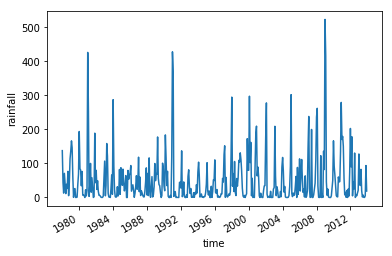

In [26]:
# PLot

month_sum.rainfall.mean(dim = ['longitude', 'latitude']).plot()
print(month_sum.time)
plt.show()

In [27]:
# This function calculates the residual mass rainfall curve

def calculate_residual_mass_curve(a):
    # find the number of time steps (ie. years)
    
    n = len(a.rainfall.time)/12
    
    # First calculate a cumulative rainfall xarray from the rainfall data
    
    arr = a.rainfall.values
    
    cum_rf = np.cumsum(arr, axis = 0)
    
    cum_rf_xr = xr.DataArray(cum_rf, dims = ('time', 'latitude', 'longitude'),
                            coords = [a.time, a.latitude, a.longitude])
    
    # NOw we will calculate a cumulative rainfall assuming average rainfall on a month by month basis
    # Find the average of all months
    ave_months = a.rainfall.groupby('time.month').mean('time').values
   
    # In the case that we are not starting from January we will need to reorder the array
    
    start_month = a.time[0].dt.month.values - 1
    
    ave_month = np.concatenate((ave_months[start_month:,:,:], ave_months[0:start_month,:,:]), axis = 0)

    
    # Tile an array so that we can run a cumulative sum on it
    tiled_ave = np.tile(ave_months, (round(n), 1, 1))
    
    # In the case that we have residual months remove them from the tiled array
    if (n).is_integer() == False:
        month_remainder = int(round((n%1) * 12))

        tiled_ave = tiled_ave[:int(-month_remainder),:,:]
        
    # Generate the cumulative sum of rainfall one would get assuming average rainfall every month
    cum_ave = np.cumsum(tiled_ave, axis = 0)
    
    cum_ave_xr = xr.DataArray(cum_ave, dims = ('time', 'latitude', 'longitude'),
                              coords = [a.time, a.latitude, a.longitude])
    
    # The mass residual curve is the difference between the cumulativer rainfall data and the cumulative
    # rainfall one would get iff the average always occured
    mass_res_curve = cum_rf_xr - cum_ave_xr
    
    return mass_res_curve

In [28]:
mass_res_curve = calculate_residual_mass_curve(month_sum)    


plt.show()

In [29]:

# NOw grounp the mass residual curve by calendar year
yearly_mass_res = mass_res_curve.groupby('time.year').mean()

yearly_mass_res



<xarray.DataArray (year: 36)>
array([  -51.33231 ,   121.099525,   130.290771,   476.649414,   367.283539,
         217.544632,   242.637619,   124.393585,    43.510479,  -143.83226 ,
        -340.786682,  -305.051117,  -239.670486,   184.098633,   -79.873329,
        -427.145264,  -711.192078, -1064.427246, -1353.418823, -1516.159668,
       -1356.432495, -1240.036255,  -903.930359,  -751.386902,  -796.274475,
       -1009.704285, -1218.473145, -1281.191528, -1351.167725, -1279.142944,
       -1009.111267,  -346.471954,  -379.681732,    63.430134,   188.409714,
          53.97168 ])
Coordinates:
  * year     (year) int64 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 ...

In [30]:
# Set name for meging purposes

yearly_mass_res.name = 'Averaged mass residual'

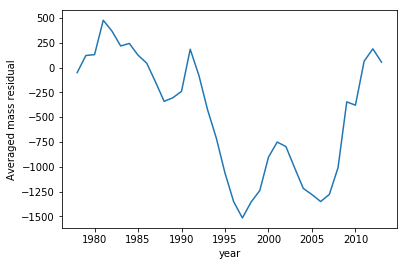

In [31]:
yearly_mass_res.plot()
plt.show()

In [32]:
# Now slice the data array between the years of interest

sliced_yearly_mass_res = yearly_mass_res.loc[dict(year = slice(start_of_epoch.split('-')[0], end_of_epoch.split('-')[0]))]
len(sliced_yearly_mass_res)

27

In [33]:
# NOw we want to split the residual mass into trending periods. For this we will define a function for extracting
# linear regression slopes on variable window sizes with various start and end points

def extract_trend(mass_res, min_length = 4):
    
    results = []
    
    for i in range(min_length, len(mass_res) + 1):
        for j in range(0, len(mass_res) - (i - 1)):

            arr = mass_res.values[j: j + i]

            start_yr = mass_res[j].year.values
            end_yr = mass_res[j + i - 1].year.values
            slope, intercept, r, p_value, std_err = stats.linregress(np.arange(0,len(arr)), arr)
            
            results.append([start_yr, end_yr, slope, p_value, r**2])
            

    return np.array(results)


a = extract_trend(sliced_yearly_mass_res, 5)                        
            

In [34]:
print(a[-1])

[  1.98700000e+03   2.01300000e+03  -4.79462413e+00   7.30097054e-01
   4.84523592e-03]


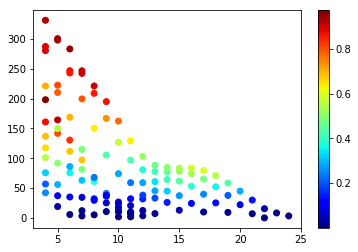

In [35]:
# Find the greatest positive trend. For this we need to weight up multiple criteria. We want a strong trend (ie. large
# slope coefficient) as well as a long time period and statistical significance (ie. p_value < 0.05)

# To examine this a bit more we plot 


# Keep only positive a

pos_a = a[a[:,2] > 0]

nyears = pos_a[:,1] - pos_a[:,0]
slopes = pos_a[:,2]
r_squ = pos_a[:,4]

plt.scatter(x = nyears, y = slopes, c = r_squ, cmap=cm.jet)
plt.colorbar()
plt.show()

In [36]:
# This problem really becomes one of weighing up criteria. For the sake of this we will produce a 'function' for decision
# making

def scale(a):
    scaled = np.array([np.float(i)/np.sum(a) for i in a])

    return scaled

def pick_best_range(slope, nyears, r_squ):
    
    # first scale the data so the magnitude matters less
    
    slope_sc = scale(slope)
    nyears_sc = scale(nyears)
    r_squ_sc = scale(r_squ)
    
    # define coefficients
    a = 0.7
    b = 1
    c = 1
    
    # multiply the dataests by these numbers
    
    slope_wtd = a * slope_sc
    nyears_wtd = b * nyears_sc
    r_squ_wtd = c * r_squ_sc
    
    # Sum the criteria
    
    score = np.sum([slope_wtd, nyears_wtd, r_squ_wtd], axis = 0)
    
    
    # Find the maximum of the summed array
    
    idx = np.argmax(score)
    
    return idx



In [37]:
best_idx = pick_best_range(slopes, nyears, r_squ)
pos_year_range = pos_a[best_idx,0:2]
print(pos_year_range)

[ 2007.  2011.]


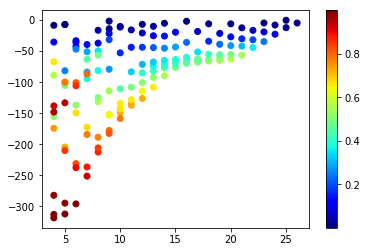

In [38]:
# Do the same for the negative trend


# Keep only negative a
neg_a = a[a[:,2] < 0]

nyears = neg_a[:,1] - neg_a[:,0]
slopes = neg_a[:,2]
r_squ = neg_a[:,4]

plt.scatter(x = nyears, y = slopes, c = r_squ, cmap=cm.jet)
plt.colorbar()
plt.show()

In [39]:
best_idx = pick_best_range(-1 * slopes, nyears, r_squ)
neg_year_range = neg_a[best_idx,0:2]
print(neg_year_range)

[ 1991.  1996.]


In [40]:
# Now we get back to our nbar data and we calculate the 25th percentile NDVI for each year

def quantile(x):
    return x.quantile(0.25, dim = 'time')


ndvi_p25 = all_sens.ndvi.groupby('time.year').apply(quantile)

ndvi_p25

<xarray.DataArray 'ndvi' (year: 31, y: 312, x: 321)>
array([[[ 0.335352,  0.414973, ...,  0.281145,  0.278196],
        [ 0.330504,  0.398363, ...,  0.302033,  0.305738],
        ..., 
        [ 0.2014  ,  0.196416, ...,  0.334819,  0.315314],
        [ 0.200377,  0.18917 , ...,  0.323645,  0.32247 ]],

       [[ 0.399439,  0.437528, ...,  0.418327,  0.411425],
        [ 0.40161 ,  0.425278, ...,  0.429911,  0.42913 ],
        ..., 
        [ 0.235388,  0.224702, ...,  0.355838,  0.333978],
        [ 0.2402  ,  0.213009, ...,  0.33486 ,  0.34267 ]],

       ..., 
       [[ 0.388594,  0.430639, ...,  0.412043,  0.406223],
        [ 0.399356,  0.436113, ...,  0.418801,  0.410121],
        ..., 
        [ 0.125565,  0.107643, ...,  0.381008,  0.375619],
        [ 0.141351,  0.144754, ...,  0.363496,  0.363782]],

       [[ 0.356122,  0.42484 , ...,  0.409965,  0.388663],
        [ 0.358548,  0.436382, ...,  0.423128,  0.415996],
        ..., 
        [ 0.119413,  0.117577, ...,  0.358325,

In [41]:
from scipy import stats


#This function applies a linear regression to a grid over a set time interval
def linear_regression_grid(input_array, mask_no_trend = False, NDVI = False):
    '''
    This function applies a linear regression to a grid over a set time interval by looping through lat and lon 
    and calculating the linear regression through time for each pixel.
    '''
    print(input_array.year)
    ylen = len(input_array.y)
    xlen = len(input_array.x)
    from itertools import product
    coordinates = product(range(ylen), range(xlen))

    slopes = np.zeros((ylen, xlen))
    p_values = np.zeros((ylen, xlen))
    print('Slope shape is ', slopes.shape)

    for y, x in coordinates:
        val = input_array.isel(x = x, y = y)
        # If analysing NDVI data replace negative numbers which are spurious for NDVI with nans
        if NDVI == True:
            val[val<0] = np.nan

            # Check that we have at least three values to perform our linear regression on
            if np.count_nonzero(~np.isnan(val)) > 3:
                if str(val.dims[0]) == 'month':
                    slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.month,val)
                elif str(val.dims[0]) == 'year':
                    slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.year,val)
            else:
                slopes[y, x] = np.nan
                intercept = np.nan
                r_sq = np.nan
                p_values[y, x] = np.nan
        else:
            if str(val.dims[0]) == 'month':
                slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.month,val)
            elif str(val.dims[0]) == 'year':
                slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.year,val)

    #Get coordinates from the original xarray
    lat  = input_array.coords['y']
    long = input_array.coords['x']
    #Mask out values with insignificant trends (ie. p-value > 0.05) if user wants
    if mask_no_trend == True:
        slopes[p_values>0.05]=np.nan        
    # Write arrays into a x-array
    slope_xr = xr.DataArray(slopes, coords = [lat, long], dims = ['y', 'x'])
    p_val_xr = xr.DataArray(p_values, coords = [lat, long], dims = ['y', 'x']) 
    return slope_xr, p_val_xr

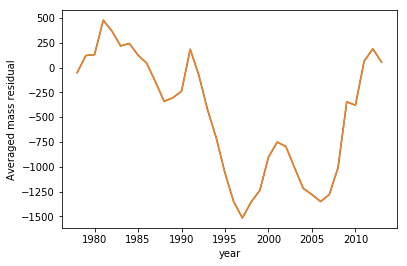

In [70]:
yearly_mass_res.plot()
plt.show()

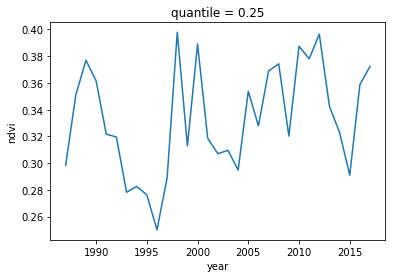

In [68]:
ndvi_p25.mean(dim=('x','y')).plot()

plt.show()

In [42]:
# Slice using the positive and negative mass residual rainfall trends desccribed above

pos_rmc_slope_ndvi = ndvi_p25.sel(year = slice(pos_year_range[0],pos_year_range[1]))

In [43]:
pos_rmc_slope_ndvi

<xarray.DataArray 'ndvi' (year: 5, y: 312, x: 321)>
array([[[ 0.421347,  0.457888, ...,  0.443345,  0.420752],
        [ 0.424827,  0.444796, ...,  0.420732,  0.426742],
        ..., 
        [ 0.121176,  0.12487 , ...,  0.367013,  0.370554],
        [ 0.12916 ,  0.130133, ...,  0.366258,  0.379278]],

       [[ 0.386366,  0.417414, ...,  0.403911,  0.403815],
        [ 0.380867,  0.413343, ...,  0.430635,  0.444988],
        ..., 
        [ 0.125034,  0.118014, ...,  0.369612,  0.35265 ],
        [ 0.125636,  0.120173, ...,  0.371274,  0.381366]],

       ..., 
       [[ 0.409214,  0.409877, ...,  0.444892,  0.412151],
        [ 0.400334,  0.3867  , ...,  0.442864,  0.393202],
        ..., 
        [ 0.105554,  0.110602, ...,  0.402755,  0.39036 ],
        [ 0.120762,  0.129852, ...,  0.386384,  0.408488]],

       [[ 0.394148,  0.422251, ...,  0.428407,  0.389009],
        [ 0.393489,  0.443096, ...,  0.410323,  0.402184],
        ..., 
        [ 0.122959,  0.077014, ...,  0.369558, 

In [44]:
# Slice using the positive and negative mass residual rainfall trends desccribed above

neg_rmc_slope_ndvi = ndvi_p25.sel(year = slice(neg_year_range[0],neg_year_range[1]))

In [45]:
neg_rmc_slope_ndvi

<xarray.DataArray 'ndvi' (year: 6, y: 312, x: 321)>
array([[[ 0.353277,  0.354115, ...,  0.321827,  0.295156],
        [ 0.396501,  0.378595, ...,  0.307613,  0.305675],
        ..., 
        [ 0.300997,  0.266462, ...,  0.316139,  0.321141],
        [ 0.28507 ,  0.254549, ...,  0.335655,  0.319202]],

       [[ 0.289012,  0.334803, ...,  0.32901 ,  0.328189],
        [ 0.287563,  0.349935, ...,  0.341538,  0.324403],
        ..., 
        [ 0.231051,  0.196667, ...,  0.331462,  0.314583],
        [ 0.23615 ,  0.199269, ...,  0.322756,  0.301509]],

       ..., 
       [[ 0.350693,  0.37819 , ...,  0.344885,  0.352468],
        [ 0.36496 ,  0.393204, ...,  0.338825,  0.336918],
        ..., 
        [ 0.141883,  0.133746, ...,  0.270873,  0.268546],
        [ 0.156204,  0.138195, ...,  0.26502 ,  0.261061]],

       [[ 0.272507,  0.324067, ...,  0.300978,  0.289133],
        [ 0.268159,  0.321192, ...,  0.30582 ,  0.321161],
        ..., 
        [ 0.124759,  0.123378, ...,  0.239343, 

In [46]:
# Run linear regression

slope_xr, p_val_xr = linear_regression_grid(pos_rmc_slope_ndvi)

<xarray.DataArray 'year' (year: 5)>
array([2007, 2008, 2009, 2010, 2011])
Coordinates:
    quantile  float64 0.25
  * year      (year) int64 2007 2008 2009 2010 2011
Slope shape is  (312, 321)


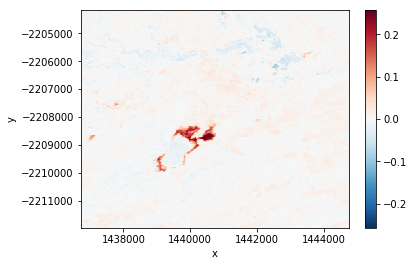

In [47]:
# Plot the grid

slope_xr.plot()
#plt.savefig('/home/547/njs547/DEA_hack.png')
plt.show()

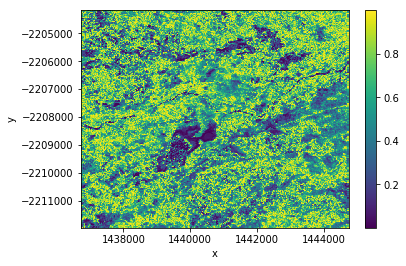

In [48]:

p_val_xr.plot()

plt.show()

In [49]:
# Run linear regression

slope_xr_n, p_val_xr_n = linear_regression_grid(neg_rmc_slope_ndvi)

<xarray.DataArray 'year' (year: 6)>
array([1991, 1992, 1993, 1994, 1995, 1996])
Coordinates:
    quantile  float64 0.25
  * year      (year) int64 1991 1992 1993 1994 1995 1996
Slope shape is  (312, 321)


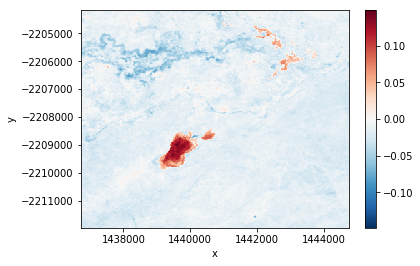

In [50]:
# Plot the grid

slope_xr_n.plot()
#plt.savefig('/home/547/njs547/DEA_hack.png')
plt.show()

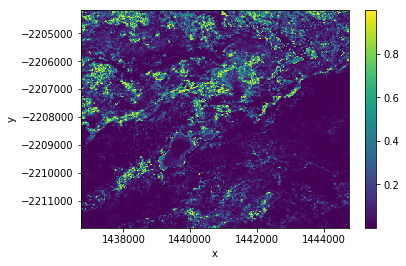

In [51]:
p_val_xr_n.plot()

plt.show()

 MAss residual curve idexed Hovmoller plots

In [71]:

# This function is used to plot the hovmoller plot. HEre we assign a y index (ie. 
#index of constant y coordinate) but the function could be adapted to take in shapefiles.

def plot_hov(sliced_all_sens, y_index = 300):
       
    
    #Define colour strecthes    
    ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
    ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
    ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

    # Plot

    fig = plt.figure(figsize=(11.69,8.27))

    # Write an new dataset using 
    sliced_all_sens.ndvi.isel(y = y_index).plot(norm= ndvi_norm, cmap = ndvi_cmap, yincrease = False)

    ax = plt.gca()

    plt.grid(True)
    plt.show()

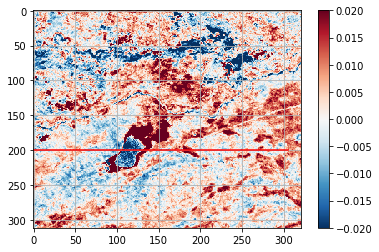

In [61]:
# Choose the y index
plt.imshow(slope_xr,cmap='RdBu_r', aspect='auto', vmin=-0.02, vmax=0.02)
#slope_xr.plot()

yindex = 200

plt.plot([0,305], [yindex , yindex], 'r')
plt.grid(True)
plt.colorbar()
plt.show()

In [62]:
# This function is a hacky slice using years

def hack_slice(ds, years):
    # Yearly data will be appended to a list
    year_chunks = []
    
    # Iterate through input years
    for item in years:

        year = str(item)

        t = ds.time.dt.year
        
        # If the years exist in the satellite data
        if len(t.loc[year]) != 0:
            # This is a very hacky slice using a mask because regular slicing was not possible due to a bug in xarray
            mask = t.where(t == int(year), drop = True)
            sliced_ds = ds.loc[dict(time = mask.time)]
            # Append the results to a list
            year_chunks.append(sliced_ds)
            
    # Finall concatenate all of the data into a new dataset

    sliced_ds = xr.concat(year_chunks, dim = 'time')
    return sliced_ds


[2007, 2008, 2009, 2010]


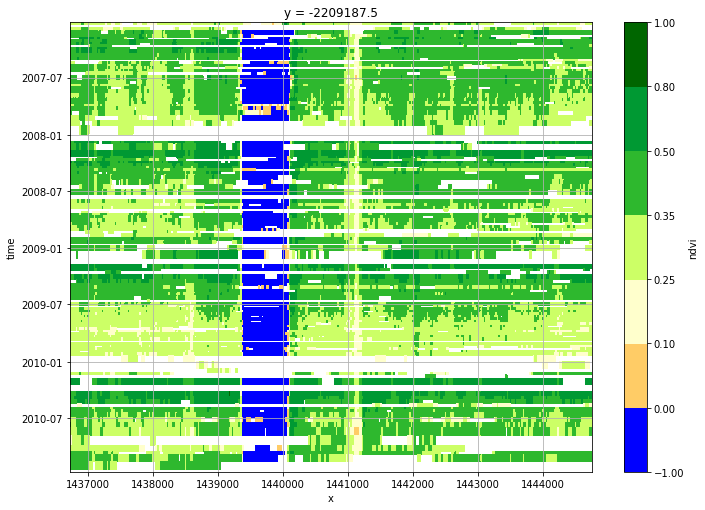

In [64]:
# Plot Hovmoller for the positive trend

years = np.arange(int(pos_year_range[0]), int(pos_year_range[1]), 1)

years = [int(x) for x in years]

print(years)

pos_rmc_slope_all_sens = hack_slice(all_sens, years)
#print(pos_rmc_slope_all_sens.time)

plot_hov(pos_rmc_slope_all_sens, y_index = yindex)


[1991, 1992, 1993, 1994, 1995]


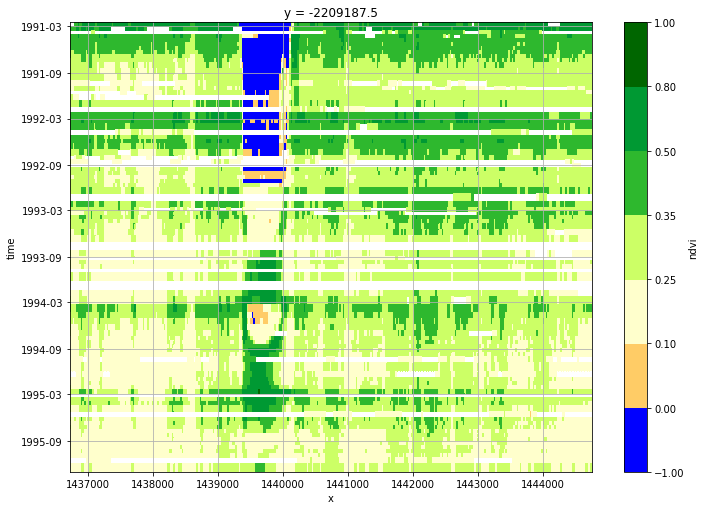

In [66]:
# Plot Hovmoller for the negative trend

years = np.arange(int(neg_year_range[0]), int(neg_year_range[1]), 1)

years = [int(x) for x in years]

print(years)

neg_rmc_slope_all_sens = hack_slice(all_sens, years)
#print(neg_rmc_slope_all_sens.time)

plot_hov(neg_rmc_slope_all_sens, y_index = yindex)